In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left

# Create Store
Create a store using [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 
Here, we create a store to hold the results for the experiment.

In [15]:
# STORE_PATH = '<Give Store Path Here>'
# STORE_TABLE_NAME = '<Give Store Table Name Here>'
STORE_PATH = '/home/pstefanou/test_'
STORE_TABLE_NAME = 'test'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_param_mse': float,
    'delphi_var_mse': float, 
    'var': float, 
    'ols_param_mse': float, 
    'ols_var_mse': float,
    'alpha': float, 
    'c': float,
})

Logging in: /home/pstefanou/test_/9e77c716-fe3e-4e80-ae85-203cc87bd01f


# Experiment
Run experiment, where the truncation parameter C is varied over the range \[-5, 1\]. Each time that the experiment is run, we generate new data, and re-run the same procedure. All results from the experiment are stored within the store that is initialized in the previous cell.

In [16]:
# regression parameters
num_samples, dims = 1000, 10
noise_var = Tensor([5.0])
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)

# perform each experiment a total of 10 times
for iter_ in range(10):        
    for c in range(-4, 2):
        # generate data
        X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(noise_var)).sample(ch.Size([num_samples]))
        # truncate
        phi = Left(Tensor([c]))
        indices = phi(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]

        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/num_samples]), 
            'phi': phi, 
            'epochs': 50,
            'num_workers': 2, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 2.0, 
            'var_lr': 1e-2,
            'lr': 1e-1,
            'unknown': True, 
            'shuffle': True
        })


        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True)
        
        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr)

        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach().cpu()
        w = results.v.detach().cpu()*var_
        w0 = results.bias.detach().cpu()*var_
        # calculate metrics 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        delphi_params = ch.cat([w, w0])
        delphi_param_mse = mean_squared_error(delphi_params, real_params)
        delphi_var_mse = mean_squared_error(var_, noise_var)
        ols_param_mse = mean_squared_error(ols_params, real_params)
        ols_var_mse = mean_squared_error(noise_var, data.lambda_.inverse())

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_param_mse': delphi_param_mse,
            'delphi_var_mse': delphi_var_mse, 
            'var': float(noise_var), 
            'ols_param_mse': ols_param_mse,
            'ols_var_mse': ols_var_mse,
            'alpha': float(args.alpha.flatten()),
            'c': c
        })

# close current store
store.close()

Epoch:1 | Loss 2.1658 | Train1 0.183 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.61it/s]
Epoch:2 | Loss 2.1678 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 63.55it/s]
Epoch:3 | Loss 2.1670 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.51it/s]
Epoch:4 | Loss 2.1723 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.22it/s]
Epoch:5 | Loss 2.1755 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 54.97it/s]
Epoch:6 | Loss 2.1871 | Train1 0.183 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.28it/s]
Epoch:7 | Loss 2.1755 | Train1 0.183 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.61it/s]
Epoch:8 | Loss 2.1847 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.83it/s]
Epoch:9 | Loss 2.2042 | Train1 0

Epoch:35 | Loss 1.9565 | Train1 0.211 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 26.74it/s]
Epoch:36 | Loss 1.9431 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 21.29it/s]
Epoch:37 | Loss 1.9513 | Train1 0.208 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 21.43it/s]
Epoch:38 | Loss 1.9305 | Train1 0.208 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 21.37it/s]
Epoch:39 | Loss 1.9516 | Train1 0.211 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 20.39it/s]
Epoch:40 | Loss 2.0024 | Train1 0.211 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 20.79it/s]
Epoch:41 | Loss 1.9696 | Train1 0.208 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 20.94it/s]
Epoch:42 | Loss 1.9621 | Train1 0.214 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 13.45it/s]
Epoch:43 | Loss 1.9416 | Train1 0.209 | 

Epoch:21 | Loss 0.9984 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 26.29it/s]
Epoch:22 | Loss 1.0315 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.48it/s]
Epoch:23 | Loss 0.9808 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 52.50it/s]
Epoch:24 | Loss 0.9985 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.12it/s]
Epoch:25 | Loss 1.0557 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.85it/s]
Epoch:26 | Loss 1.0840 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 53.20it/s]
Epoch:27 | Loss 1.0377 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 55.29it/s]
Epoch:28 | Loss 1.0368 | Train1 0.149 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 50.29it/s]
Epoch:29 | Loss 1.0239 | Train1 0.149 | 

Epoch:5 | Loss 1.7817 | Train1 0.187 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.43it/s]
Epoch:6 | Loss 1.7996 | Train1 0.180 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.35it/s]
Epoch:7 | Loss 1.8149 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 63.06it/s]
Epoch:8 | Loss 1.8135 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 63.78it/s]
Epoch:9 | Loss 2.0166 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.74it/s]
Epoch:10 | Loss 1.8371 | Train1 0.183 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.79it/s]
Epoch:11 | Loss 1.8806 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 64.25it/s]
Epoch:12 | Loss 1.8890 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 63.00it/s]
Epoch:13 | Loss 1.8536 | Trai

Epoch:40 | Loss 2.0325 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 54.87it/s]
Epoch:41 | Loss 2.1012 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 55.30it/s]
Epoch:42 | Loss 2.1367 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 54.86it/s]
Epoch:43 | Loss 2.1214 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 55.55it/s]
Epoch:44 | Loss 2.1433 | Train1 0.224 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 59.35it/s]
Epoch:45 | Loss 2.1477 | Train1 0.224 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 56.76it/s]
Epoch:46 | Loss 2.1316 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 58.18it/s]
Epoch:47 | Loss 2.1660 | Train1 0.223 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 55.55it/s]
Epoch:48 | Loss 2.1917 | Train1 0.223 | 

Epoch:25 | Loss 1.9952 | Train1 0.180 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.49it/s]
Epoch:26 | Loss 2.0192 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 61.24it/s]
Epoch:27 | Loss 2.0174 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 62.97it/s]
Epoch:28 | Loss 1.9988 | Train1 0.183 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.05it/s]
Epoch:29 | Loss 2.0367 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.56it/s]
Epoch:30 | Loss 2.0085 | Train1 0.181 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.44it/s]
Epoch:31 | Loss 1.9960 | Train1 0.180 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.47it/s]
Epoch:32 | Loss 2.0301 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 61.05it/s]
Epoch:33 | Loss 2.0096 |

Epoch:10 | Loss 1.3586 | Train1 0.260 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 58.20it/s]
Epoch:11 | Loss 1.3931 | Train1 0.260 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 54.56it/s]
Epoch:12 | Loss 1.4082 | Train1 0.261 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 58.69it/s]
Epoch:13 | Loss 1.4209 | Train1 0.263 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 57.42it/s]
Epoch:14 | Loss 1.4140 | Train1 0.263 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 53.88it/s]
Epoch:15 | Loss 1.4426 | Train1 0.263 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 57.06it/s]
Epoch:16 | Loss 1.4715 | Train1 0.261 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 54.12it/s]
Epoch:17 | Loss 1.5591 | Train1 0.264 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 57.64it/s]
Epoch:18 | Loss 1.4690 | Train1 0.264 | 

Epoch:45 | Loss 2.4636 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 61.87it/s]
Epoch:46 | Loss 2.4675 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.81it/s]
Epoch:47 | Loss 2.4729 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.92it/s]
Epoch:48 | Loss 2.4751 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 21.79it/s]
Epoch:49 | Loss 2.4699 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 21.18it/s]
Epoch:50 | Loss 2.4666 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 20.84it/s]
Epoch:1 | Loss 2.0183 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s]
Epoch:2 | Loss 2.0191 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 22.66it/s]
Epoch:3 | Loss 2.0207 | Tr

Epoch:30 | Loss 2.1066 | Train1 0.225 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 63.50it/s]
Epoch:31 | Loss 1.9483 | Train1 0.229 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 60.96it/s]
Epoch:32 | Loss 1.8860 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 62.49it/s]
Epoch:33 | Loss 2.0365 | Train1 0.235 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 59.12it/s]
Epoch:34 | Loss 1.8784 | Train1 0.233 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 58.55it/s]
Epoch:35 | Loss 1.9059 | Train1 0.232 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 60.02it/s]
Epoch:36 | Loss 1.8858 | Train1 0.225 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 61.51it/s]
Epoch:37 | Loss 1.7695 | Train1 0.227 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 60.94it/s]
Epoch:38 | Loss 1.7826 | Train1 0.229 | 

Epoch:16 | Loss 2.3754 | Train1 0.171 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.38it/s]
Epoch:17 | Loss 2.4021 | Train1 0.169 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.86it/s]
Epoch:18 | Loss 2.4149 | Train1 0.172 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.80it/s]
Epoch:19 | Loss 2.3892 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 57.64it/s]
Epoch:20 | Loss 2.3777 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.45it/s]
Epoch:21 | Loss 2.3698 | Train1 0.171 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.88it/s]
Epoch:22 | Loss 2.3690 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.46it/s]
Epoch:23 | Loss 2.3668 | Train1 0.171 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 62.86it/s]
Epoch:24 | Loss 2.3358 |

Epoch:1 | Loss 1.6082 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 57.69it/s]
Epoch:2 | Loss 1.6081 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 60.16it/s]
Epoch:3 | Loss 1.6111 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 58.25it/s]
Epoch:4 | Loss 1.6289 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 54.99it/s]
Epoch:5 | Loss 1.6264 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 57.32it/s]
Epoch:6 | Loss 1.6443 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 57.52it/s]
Epoch:7 | Loss 1.6528 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 59.67it/s]
Epoch:8 | Loss 1.6775 | Train1 0.203 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 8/8 [00:00<00:00, 58.56it/s]
Epoch:9 | Loss 1.6769 | Train1 0.204 | Train5 -1

Epoch:37 | Loss 1.6577 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.84it/s]
Epoch:38 | Loss 1.6912 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 60.60it/s]
Epoch:39 | Loss 1.4896 | Train1 0.153 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 62.29it/s]
Epoch:40 | Loss 1.4948 | Train1 0.153 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 60.65it/s]
Epoch:41 | Loss 1.5083 | Train1 0.153 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 63.78it/s]
Epoch:42 | Loss 1.6265 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 60.38it/s]
Epoch:43 | Loss 1.6291 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.51it/s]
Epoch:44 | Loss 1.6788 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 61.32it/s]
Epoch:45 | Loss 1.6778 | Train1 0.151 | 

Epoch:21 | Loss 2.0448 | Train1 0.181 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 56.81it/s]
Epoch:22 | Loss 1.9897 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 56.95it/s]
Epoch:23 | Loss 1.9677 | Train1 0.178 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 61.40it/s]
Epoch:24 | Loss 1.9494 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 55.77it/s]
Epoch:25 | Loss 1.9880 | Train1 0.179 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 60.08it/s]
Epoch:26 | Loss 1.9831 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 59.05it/s]
Epoch:27 | Loss 1.9627 | Train1 0.181 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 59.70it/s]
Epoch:28 | Loss 2.0068 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 57.95it/s]
Epoch:29 | Loss 1.9756 | Train1 0.175 | 

Epoch:7 | Loss 1.0023 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 55.36it/s]
Epoch:8 | Loss 0.9973 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 53.55it/s]
Epoch:9 | Loss 1.0057 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 55.34it/s]
Epoch:10 | Loss 1.0118 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 55.80it/s]
Epoch:11 | Loss 1.0142 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 53.92it/s]
Epoch:12 | Loss 1.0216 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 51.04it/s]
Epoch:13 | Loss 1.0232 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 58.00it/s]
Epoch:14 | Loss 1.0114 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]
Epoch:15 | Loss 1.0292 | Train1 0.164 | Tra

Epoch:41 | Loss 2.1450 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.16it/s]
Epoch:42 | Loss 2.1077 | Train1 0.168 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.18it/s]
Epoch:43 | Loss 2.0893 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.30it/s]
Epoch:44 | Loss 2.0945 | Train1 0.170 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.54it/s]
Epoch:45 | Loss 2.0931 | Train1 0.168 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 63.85it/s]
Epoch:46 | Loss 2.0883 | Train1 0.168 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.20it/s]
Epoch:47 | Loss 2.0964 | Train1 0.168 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 62.02it/s]
Epoch:48 | Loss 2.1017 | Train1 0.167 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.88it/s]
Epoch:49 | Loss 2.0948 |

Epoch:27 | Loss 1.6245 | Train1 0.242 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 16.47it/s]
Epoch:28 | Loss 1.6597 | Train1 0.242 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 16.48it/s]
Epoch:29 | Loss 1.5752 | Train1 0.242 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 16.21it/s]
Epoch:30 | Loss 1.6238 | Train1 0.244 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 16.32it/s]
Epoch:31 | Loss 1.6157 | Train1 0.242 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 17.42it/s]
Epoch:32 | Loss 1.6551 | Train1 0.244 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 16.23it/s]
Epoch:33 | Loss 1.5854 | Train1 0.241 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 16.58it/s]
Epoch:34 | Loss 1.6313 | Train1 0.242 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 16.65it/s]
Epoch:35 | Loss 1.7134 | Train1 0.242 | 

Epoch:12 | Loss 2.1349 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 62.89it/s]
Epoch:13 | Loss 2.1559 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.10it/s]
Epoch:14 | Loss 2.1430 | Train1 0.172 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.07it/s]
Epoch:15 | Loss 2.1482 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 62.48it/s]
Epoch:16 | Loss 2.1610 | Train1 0.177 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.04it/s]
Epoch:17 | Loss 2.1380 | Train1 0.175 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 57.52it/s]
Epoch:18 | Loss 2.1386 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.57it/s]
Epoch:19 | Loss 2.1474 | Train1 0.178 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 56.94it/s]
Epoch:20 | Loss 2.1318 |

Epoch:47 | Loss 1.9691 | Train1 0.216 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 61.17it/s]
Epoch:48 | Loss 1.9745 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 61.92it/s]
Epoch:49 | Loss 1.9674 | Train1 0.214 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 60.18it/s]
Epoch:50 | Loss 1.9685 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 58.30it/s]
Epoch:1 | Loss 1.1866 | Train1 0.240 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 58.60it/s]
Epoch:2 | Loss 1.1859 | Train1 0.240 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 53.84it/s]
Epoch:3 | Loss 1.1899 | Train1 0.240 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 60.87it/s]
Epoch:4 | Loss 1.1934 | Train1 0.238 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 7/7 [00:00<00:00, 54.89it/s]
Epoch:5 | Loss 1.2123 | Train1 0.238 | Train

Epoch:32 | Loss 2.2561 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 56.46it/s]
Epoch:33 | Loss 2.2443 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 57.36it/s]
Epoch:34 | Loss 2.2431 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.38it/s]
Epoch:35 | Loss 2.2497 | Train1 0.174 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.32it/s]
Epoch:36 | Loss 2.2468 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 58.17it/s]
Epoch:37 | Loss 2.2443 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 56.97it/s]
Epoch:38 | Loss 2.2413 | Train1 0.171 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 60.11it/s]
Epoch:39 | Loss 2.2409 | Train1 0.173 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 57.61it/s]
Epoch:40 | Loss 2.2334 |

Epoch:17 | Loss 1.8307 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 64.51it/s]
Epoch:18 | Loss 1.9333 | Train1 0.213 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 61.16it/s]
Epoch:19 | Loss 1.9390 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 62.78it/s]
Epoch:20 | Loss 1.7932 | Train1 0.204 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 61.95it/s]
Epoch:21 | Loss 1.8799 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 62.41it/s]
Epoch:22 | Loss 2.0267 | Train1 0.218 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 62.77it/s]
Epoch:23 | Loss 1.8520 | Train1 0.209 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 64.89it/s]
Epoch:24 | Loss 1.8857 | Train1 0.211 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 58.59it/s]
Epoch:25 | Loss 1.9132 | Train1 0.203 | 

Epoch:3 | Loss 2.4516 | Train1 0.151 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 57.05it/s]
Epoch:4 | Loss 2.4637 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 61.30it/s]
Epoch:5 | Loss 2.4666 | Train1 0.153 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.54it/s]
Epoch:6 | Loss 2.4633 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 56.25it/s]
Epoch:7 | Loss 2.5117 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.61it/s]
Epoch:8 | Loss 2.4794 | Train1 0.164 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 59.51it/s]
Epoch:9 | Loss 2.4739 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 56.70it/s]
Epoch:10 | Loss 2.4935 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 10/10 [00:00<00:00, 57.36it/s]
Epoch:11 | Loss 2.4821 | Train1

Epoch:37 | Loss 1.9787 | Train1 0.188 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 58.61it/s]
Epoch:38 | Loss 1.9654 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 54.61it/s]
Epoch:39 | Loss 1.9874 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 58.84it/s]
Epoch:40 | Loss 1.9842 | Train1 0.190 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 57.91it/s]
Epoch:41 | Loss 1.9930 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 60.51it/s]
Epoch:42 | Loss 2.0068 | Train1 0.190 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 57.59it/s]
Epoch:43 | Loss 2.0097 | Train1 0.191 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 57.08it/s]
Epoch:44 | Loss 1.9763 | Train1 0.193 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 9/9 [00:00<00:00, 55.56it/s]
Epoch:45 | Loss 1.9900 | Train1 0.191 | 

Epoch:23 | Loss 1.5740 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.94it/s]
Epoch:24 | Loss 1.3170 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 59.02it/s]
Epoch:25 | Loss 1.2285 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.19it/s]
Epoch:26 | Loss 1.4541 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.95it/s]
Epoch:27 | Loss 2.0564 | Train1 0.192 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 59.55it/s]
Epoch:28 | Loss 1.6373 | Train1 0.194 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.46it/s]
Epoch:29 | Loss 1.3186 | Train1 0.196 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.63it/s]
Epoch:30 | Loss 1.6289 | Train1 0.194 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 60.66it/s]
Epoch:31 | Loss 1.3618 | Train1 0.196 | 

# Results

In [17]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 4/4 [00:00<00:00, 234.44it/s]


,delphi_param_mse,delphi_var_mse,var,ols_param_mse,ols_var_mse,alpha,c,exp_id
0,0.138777,0.000002,5.0,0.086474,0.035177,0.978,-4.0,f5941cfa-1c40-403e-b81d-85c232f59a24
1,0.060257,0.173662,5.0,0.051938,0.625185,0.958,-3.0,f5941cfa-1c40-403e-b81d-85c232f59a24
2,0.064879,0.254779,5.0,0.132315,2.000414,0.885,-2.0,f5941cfa-1c40-403e-b81d-85c232f59a24
3,0.159994,0.063064,5.0,0.185893,3.328377,0.809,-1.0,f5941cfa-1c40-403e-b81d-85c232f59a24
4,0.173481,0.543669,5.0,0.398141,6.998293,0.652,0.0,f5941cfa-1c40-403e-b81d-85c232f59a24


# Plot Results

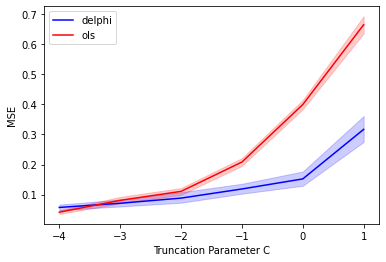

In [18]:
# plot results for regression parameter MSE
sns.lineplot(data=results, x='c', y='delphi_param_mse', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='c', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
plt.show()

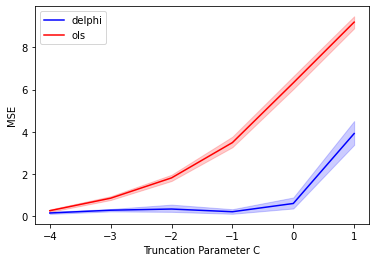

In [19]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='delphi_var_mse', label='delphi', color="blue")
ax = sns.lineplot(data=results, x='c', y='ols_var_mse', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
plt.show()